In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd

In [37]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
Base= automap_base()
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [39]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base.metadata.create_all(engine)

In [40]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [41]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
Session = Session(engine)

In [44]:
meascolumns = inspector.get_columns('measurement')
for x in meascolumns:
    print(x["name"], x["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [45]:
staticolumns = inspector.get_columns('station')
for y in staticolumns:
    print(y["name"], y["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [46]:
first_row_meas = Session.query(Measurement).first()
first_row_meas.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcfd4b6eeb0>,
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'station': 'USC00519397'}

In [47]:
first_row_stati = Session.query(Station).first()
first_row_stati.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcfd4a51490>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

latest_date = Session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date
last_twelve_mo = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_twelve_mo
prcp_data = Session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_mo).\
                    order_by(Measurement.date).all()
prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by='Date')
prcp_df.head()

# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe() 


,Precipitation
count,1.000000
mean,0.176462
std,NaN
min,0.176462
25%,0.176462
50%,0.176462
75%,0.176462
max,0.176462


<function matplotlib.pyplot.show(*args, **kw)>

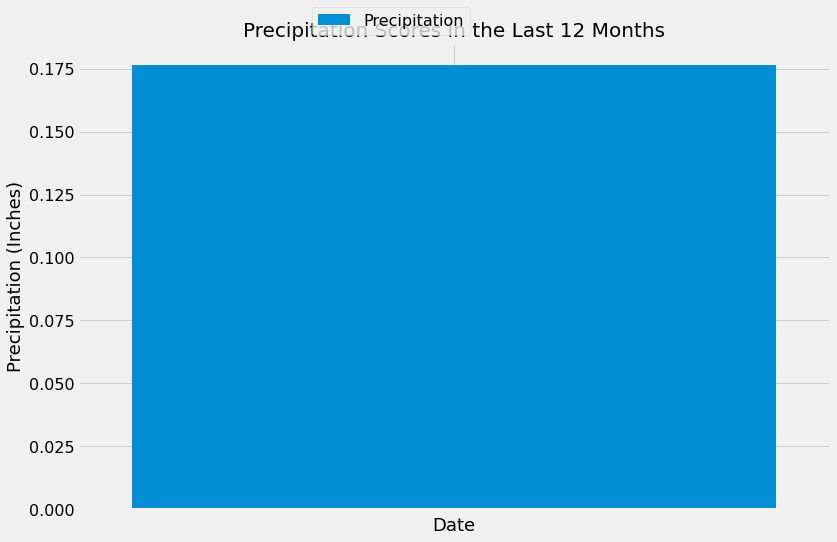

In [49]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Scores in the Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("../PrecipitationPlot.png")
plt.show

In [31]:
# Design a query to show how many stations are available in this dataset?
Session.query(Station.id).count() 

9

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stati_data = Session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
stati_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = stati_data[0][0]
Session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()


[(54.0, 71.66378066378067, 85.0)]

<function matplotlib.pyplot.show(*args, **kw)>

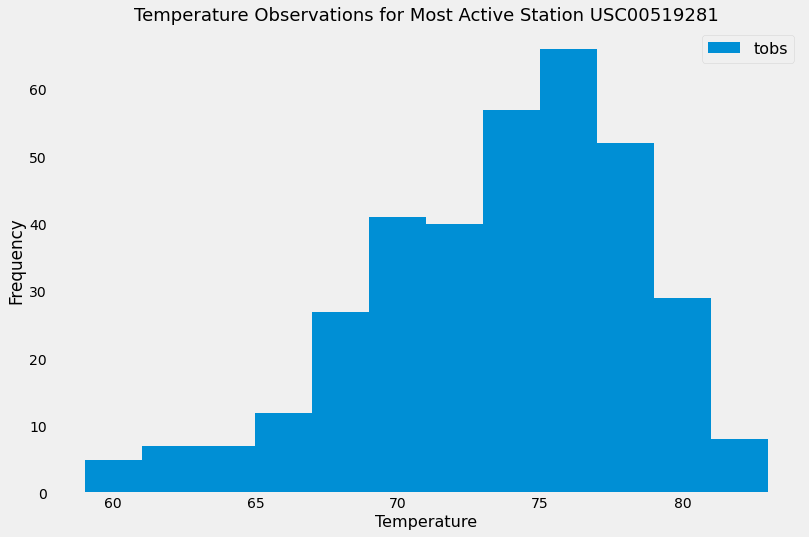

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = Session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= last_twelve_mo).all()
tobs_df = pd.DataFrame(temp_data)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

#using bins of 12 for histogram for each month
tobs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Most Active Station " + most_active_station, fontsize=18)
plt.xlabel("Temperature", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("../StationTempsHistogram.png")
plt.show

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return Session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]
